In [ ]:
import numpy as np
from numpy.random import rand
import seaborn as sns
from sklearn import tree
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
start = time.time()

In [ ]:
data = pd.read_csv("data.csv")
data  = data.values
feat  = np.asarray(data[:, 0:-1])
label = np.asarray(data[:, -1])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(feat, label, test_size=0.2, stratify=label)

In [ ]:
#def Fun(X_train,Y_train,x,opts):
  length = len(X_train)
  in_length = len(X_train[1])
  for i in range(0,length):
    temp = float()
    temp = float(sum(X_train[i])) - float(Y_train[i])
    res= math.sqrt(temp)
    print(res)


IndentationError: ignored

In [ ]:
b  = 1    
k    = 5     
N    = 57
T    = 10
fold = {'xt':X_train, 'yt':Y_train, 'xv':X_test, 'yv':Y_test}
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'b':b}


In [ ]:
def Fun(X_train, Y_train, x, opts):
    alpha    = 0.99
    beta     = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)
    if num_feat == 0:
        cost  = 1
    else:
        error = error_rate(X_train, Y_train, x, opts)
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [ ]:
def error_rate(X_train, Y_train, x, opts):
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    X_train  = xt[:, x == 1]
    Y_train  = yt.reshape(num_train) 
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  
    mdl     = KNeighborsClassifier(n_neighbors = k,metric='euclidean')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='manhattan')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='chebyshev')
    mdl.fit(X_train, Y_train)
    #mdl     = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
    #mdl.fit(X_train, Y_train)
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error

In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


In [ ]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

In [ ]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

In [ ]:
def jfs(X_train,Y_train,opts):
    
    ub    = 1
    lb    = 0
    thres = 0.5
    b     = 1      
    
    N        = opts['N']
    max_iter = opts['T']
    if 'b' in opts:
        b    = opts['b']
    
   
    dim = np.size(X_train, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
   
    X    = init_position(lb, ub, N, dim)
    
   
    Xbin = binary_conversion(X, thres, N, dim)
    
    
    fit  = np.zeros([N, 1], dtype='float')
    Xgb  = np.zeros([1, dim], dtype='float')
    fitG = float('inf')
    
    for i in range(N):
        fit[i,0] = Fun(X_train, Y_train, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
        
    
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (WOA):", curve[0,t])
    t += 1

    while t < max_iter:
        
        a = 2 - t * (2 / max_iter)
        
        for i in range(N):
           
            A = 2 * a * rand() - a
            
            C = 2 * rand()
           
            p = rand()
           
            l = -1 + 2 * rand()  
         
            if p  < 0.5:
                
                if abs(A) < 1:
                    for d in range(dim):
                       
                        Dx     = abs(C * Xgb[0,d] - X[i,d])
                        
                        X[i,d] = Xgb[0,d] - A * Dx
                      
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                
               
                elif abs(A) >= 1:
                    for d in range(dim):
                        
                        k      = np.random.randint(low = 0, high = N)
                      
                        Dx     = abs(C * X[k,d] - X[i,d])
                        
                        X[i,d] = X[k,d] - A * Dx
                        
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
            
           
            elif p >= 0.5:
                for d in range(dim):
                    
                    dist   = abs(Xgb[0,d] - X[i,d])
                   
                    X[i,d] = dist * np.exp(b * l) * np.cos(2 * np.pi * l) + Xgb[0,d] 
                   
                    X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
        
        
        Xbin = binary_conversion(X, thres, N, dim)
        
    
        for i in range(N):
            fit[i,0] = Fun(X_train, Y_train, Xbin[i,:], opts)
            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]
        
       
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (WOA):", curve[0,t])
        t += 1            

   
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)    
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    
    woa_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return woa_data

In [ ]:
time.sleep(1)
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

Generation: 1
Best (WOA): 0.16591052631578945
Generation: 2
Best (WOA): 0.15260614035087713
Generation: 3
Best (WOA): 0.1378605263157895
Generation: 4
Best (WOA): 0.10391228070175437
Generation: 5
Best (WOA): 0.10391228070175437
Generation: 6
Best (WOA): 0.10391228070175437
Generation: 7
Best (WOA): 0.10391228070175437
Generation: 8
Best (WOA): 0.10391228070175437
Generation: 9
Best (WOA): 0.10391228070175437
Generation: 10
Best (WOA): 0.10391228070175437


In [ ]:
num_train = np.size(X_train, 0)
num_valid = np.size(X_test, 0)
print(len(X_train[0]))
x_train   = X_train[:, sf]
print(len(x_train[0]))
print(sf)
y_train   = Y_train.reshape(num_train) 
x_valid   = X_test[:, sf]
y_valid   = Y_test.reshape(num_valid)


57
28
[ 0  1  4  5  7  8 13 14 16 17 18 24 25 26 28 32 33 34 36 38 39 41 44 47
 48 50 53 54]


In [ ]:
feature = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21',
       'char_freq_%24', 'char_freq_%23', 'capital_run_length_average',
       'capital_run_length_longest', 'capital_run_length_total', 'class']
print("-----------selected_features---------")
for i in sf:
  print(feature[i])

-----------selected_features---------
word_freq_make
word_freq_address
word_freq_our
word_freq_over
word_freq_internet
word_freq_order
word_freq_report
word_freq_addresses
word_freq_business
word_freq_email
word_freq_you
word_freq_hp
word_freq_hpl
word_freq_george
word_freq_lab
word_freq_data
word_freq_415
word_freq_85
word_freq_1999
word_freq_pm
word_freq_direct
word_freq_meeting
word_freq_re
word_freq_conference
char_freq_%3B
char_freq_%5B
char_freq_%23
capital_run_length_average


In [ ]:
    mdl     = KNeighborsClassifier(n_neighbors = k,metric='euclidean')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='manhattan')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='chebyshev')
    mdl.fit(x_train, y_train)
    print(mdl.predict(x_valid))
    l=mdl.predict(x_valid)  
    for i in l:
      if i==1:
        print("Spam")
      else:
        print("Ham") 

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.09999999999999998 
Precision = [0.91280654 0.87982833] 
Recall =  [0.92286501 0.8649789 ] 
F1 Score =  [0.91780822 0.87234043]
Accuracy: 90.0


[[335  28]
 [ 32 205]]


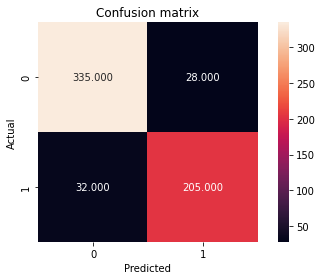

In [ ]:
conf_matrix = metrics.confusion_matrix(y_valid,y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True,color='white')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
print(conf_matrix)

In [ ]:
mdl       = DecisionTreeClassifier(criterion = "entropy", random_state = 0) 
path=mdl.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas,impurities=path.ccp_alphas,path.impurities
print("ccp alpha wil give list of values :",ccp_alphas)
print("***********************************************************")
print("Impurities in Decision Tree :",impurities)
mdl.fit(x_train, y_train)
print(mdl.predict(x_valid))

ccp alpha wil give list of values : [0.00000000e+00 6.06956083e-05 1.76186648e-04 3.14667571e-04
 3.80425551e-04 6.70963099e-04 6.76346915e-04 6.76346915e-04
 7.84120758e-04 8.12866722e-04 8.33680700e-04 8.33680700e-04
 8.33680700e-04 8.33680700e-04 8.75308658e-04 8.92750917e-04
 9.15039501e-04 9.27097944e-04 9.44002712e-04 9.78956042e-04
 1.00310733e-03 1.00760043e-03 1.01182846e-03 1.01182846e-03
 1.02291527e-03 1.04434658e-03 1.05432472e-03 1.05432472e-03
 1.09919427e-03 1.10239589e-03 1.10844346e-03 1.12476888e-03
 1.14834827e-03 1.14834827e-03 1.14834827e-03 1.14834827e-03
 1.14834827e-03 1.14834827e-03 1.14999662e-03 1.15911590e-03
 1.15911590e-03 1.16127172e-03 1.20885869e-03 1.22075157e-03
 1.22780996e-03 1.23936148e-03 1.31149191e-03 1.32857694e-03
 1.33274388e-03 1.35269383e-03 1.35269383e-03 1.35269383e-03
 1.37013609e-03 1.37013609e-03 1.37573573e-03 1.37870591e-03
 1.40452797e-03 1.42138788e-03 1.42534084e-03 1.43348073e-03
 1.43527207e-03 1.45886985e-03 1.46781624e-03 1.5

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.09999999999999998 
Precision = [0.92200557 0.86721992] 
Recall =  [0.91184573 0.88185654] 
F1 Score =  [0.91689751 0.87447699]
Accuracy: 90.0


In [ ]:
mdls=[]
for ccp_alpha in ccp_alphas:
    mdl=DecisionTreeClassifier(criterion = "entropy",random_state=0,ccp_alpha=ccp_alpha)
    mdl.fit(x_train,y_train)
    mdls.append(mdl)
print("Last node in Decision tree is {} and ccp_alpha for last node is {}".format(mdls[-1].tree_.node_count,ccp_alphas[-1]))

Last node in Decision tree is 1 and ccp_alpha for last node is 0.19403553882307112


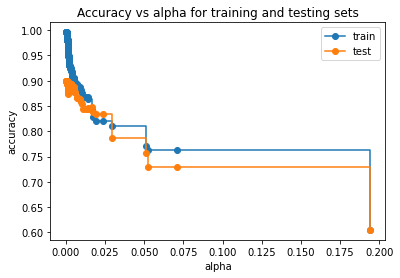

In [ ]:

train_scores = [mdl.score(x_train, y_train) for mdl in mdls]
test_scores = [mdl.score(x_valid, y_valid) for mdl in mdls]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

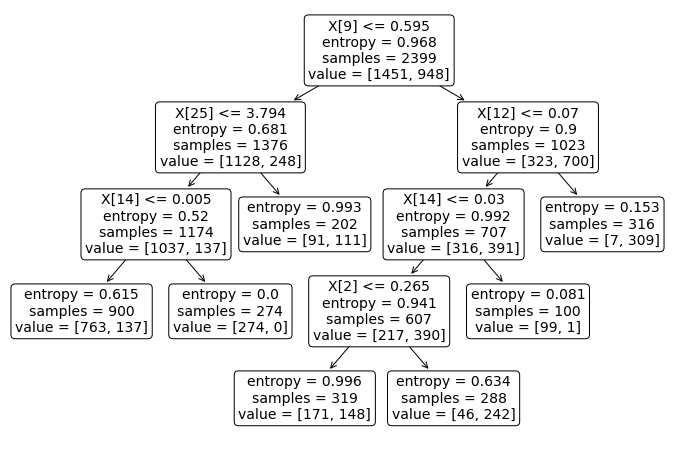

In [ ]:
mdl=DecisionTreeClassifier(criterion = "entropy",random_state=0,ccp_alpha=0.02)
mdl.fit(x_train,y_train)
plt.figure(figsize=(12,8))
tree.plot_tree(mdl,rounded=True,filled=False)
plt.show()

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.16666666666666663 
Precision = [0.83804627 0.82464455] 
Recall =  [0.89807163 0.73417722] 
F1 Score =  [0.86702128 0.77678571]
Accuracy: 83.33333333333334


In [ ]:
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=mdl,param_grid=grid_param,cv=5,n_jobs=4)
grid_search.fit(x_train,y_train)            

In [ ]:
print(grid_search.best_params_)

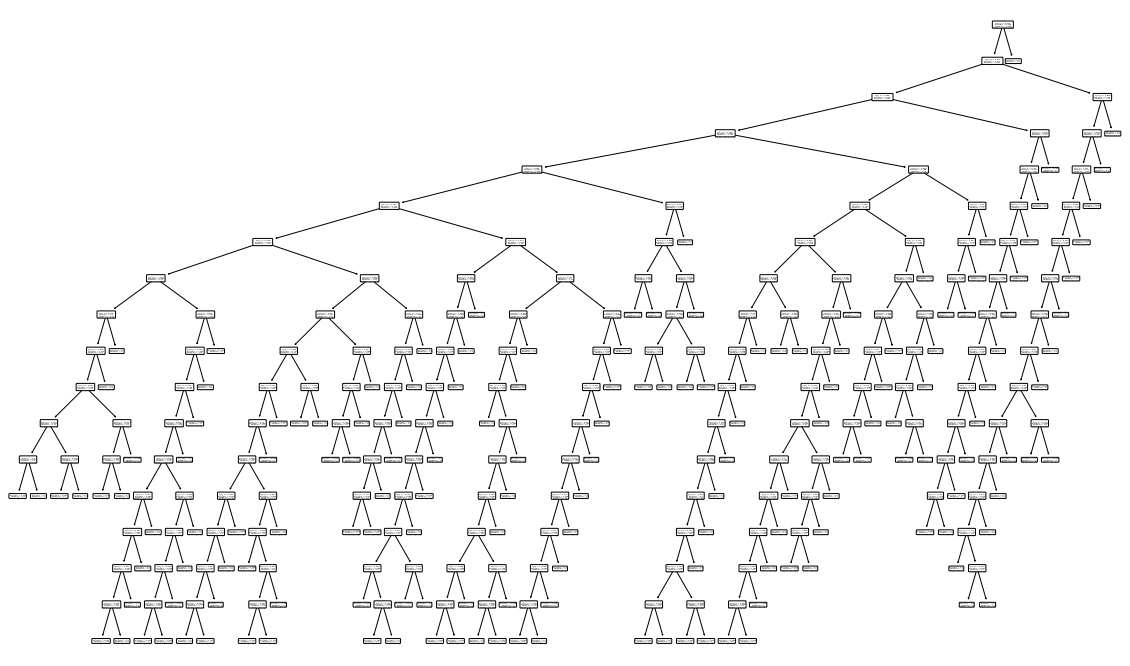

In [ ]:
mdl=DecisionTreeClassifier(criterion= 'entropy',max_depth= 17,min_samples_leaf= 3,min_samples_split= 12,splitter= 'random')
mdl.fit(x_train,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(mdl,rounded=True,filled=False)
plt.show()

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

In [ ]:
num_feat = fmdl['nf']
print("Feature Size:", num_feat)
end = time.time()
c=end-start
print("Runtime of the program is ",c)



In [ ]:
data = {'Whale Optimizer':c ,"Firefly Algorithm":247.09597516059875}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (2.5,5))
# creating the bar plot
plt.bar(courses, values, color ='cyan', width = 0.2)
plt.ylabel('Seconds')
plt.xlabel('')
plt.title("Runtime of Optimization Algorithms")
plt.show()

In [ ]:
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0
fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('Whale')
ax.grid()
plt.show()